In [6]:
import np as np
from norse.torch import LIFAdExState

In [7]:
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
)
import matplotlib.pyplot as plt

In [18]:
go_task_list_values = np.linspace(0, 1, 8)  # [5:]
batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.8,
        # positive_shift_delay_time=1.5,
        trial_time=0.2,
        positive_shift_trial_time=0.4,
        answer_time=0.25,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=1.0, answer_time=0.5)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=1.1,
        # positive_shift_trial_time=1.5,
        value=go_task_list_values,
        answer_time=0.25,
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=1.10,
        # positive_shift_trial_time=1.5,
        answer_time=1.5,
        value=go_task_list_values,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(
            trial_time=0.2,
            positive_shift_trial_time=0.4,
            answer_time=0.25,
            value=go_task_list_values,
        ),
        delay=0.8,
    )
)
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}

tasks_sequence = [
    MultyReduceTasks(
        tasks=task_dict,
        batch_size=batch_size,
        delay_between=0,
        enable_fixation_delay=True,
        task_number=i,
    )
    for i in range(len(tasks))
]

In [19]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
feature_size, output_size = tasks_sequence[0].feature_and_act_size
hidden_size = 600
tau_a = "1/2"
neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.65),
    tau_ada_inv=float(eval(tau_a)),
    alpha=100,
    method="super",
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
    return_spiking=True,
).to(device)
model.load_state_dict(
    torch.load(
        rf"A:\src\600\1_2\Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_100_N_600",
        # r"A:\src\multy_task\notebooks\train\reduce\lif_adex\romo_dm_ct_go_gort_godl\long_intervals_list_go_task_improve_correct_functions_two_trials\Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_100_N_450",
        map_location=device,
    )
)
# tau_a = neuron_parameters.tau_ada_inv

<All keys matched successfully>

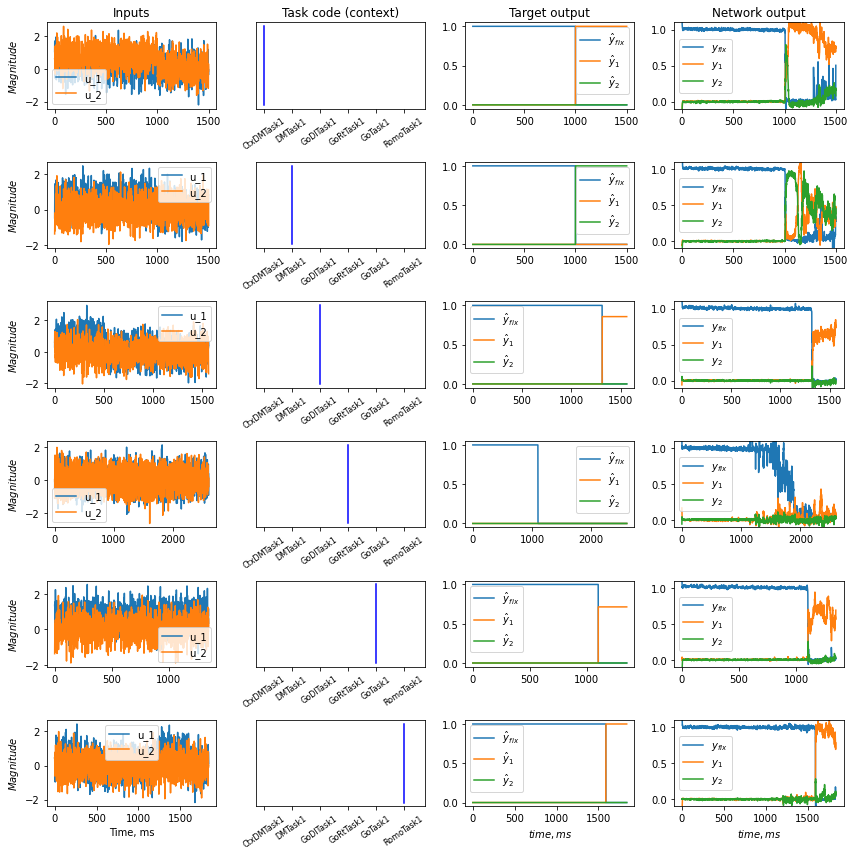

In [27]:
task_count = 1
batch = 0
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
    torch.zeros(batch_size, hidden_size).to(device),
)
plt.rcParams["font.size"] = 10
fig = plt.figure(figsize=(12, 12))
for task in tasks_sequence[::2]:
    init_state = LIFAdExState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
    )
    inputs, t_outputs = task.dataset(n_trials=1)
    inputs[:, :, 1:3] += np.random.normal(size=(len(inputs), 1, 2)) * 0.6
    inputs = torch.from_numpy(inputs).type(torch.float)
    output = model(inputs, init_state)[0]

    ax = fig.add_subplot(6, 4, task_count)
    if task_count == 1:
        plt.title("Inputs")
    if task_count == 21:
        plt.xlabel("Time, ms")
    plt.ylabel("$Magnitude$")
    for i in range(1, 3):
        plt.plot(inputs[:, batch, i], label="$u_{fix}$" if i == 0 else rf"u_{i}")
    plt.legend()

    ax = fig.add_subplot(6, 4, task_count + 1)

    if task_count == 1:
        plt.title("Task code (context)")
    # if task_count == 45:
    plt.xticks(range(0, len(tasks), 2), sorted(tasks)[::2], rotation=35, fontsize=8)
    plt.yticks([])
    for i in range(3, inputs.shape[-1]):
        plt.plot([i - 3] * 2, [0, inputs[0, batch, i]], c="b")

    ax = fig.add_subplot(6, 4, task_count + 2)
    if task_count == 1:
        plt.title("Target output")
    if task_count == 21:
        plt.xlabel("$time, ms$")
    for i in range(t_outputs.shape[-1]):
        plt.plot(
            t_outputs[:, batch, i],
            label=r"$\hat y_{fix}$" if i == 0 else rf"$\hat y_{i}$",
        )

    plt.legend()
    ax = fig.add_subplot(6, 4, task_count + 3)
    if task_count == 1:
        plt.title("Network output")
    ax.set_ylim([-0.1, 1.1])
    if task_count == 21:
        plt.xlabel("$time, ms$")
    for i in range(t_outputs.shape[-1]):
        plt.plot(
            output[:, batch, i].detach().cpu(),
            label="$y_{fix}$" if i == 0 else rf"$y_{i}$",
        )
    plt.legend()
    del inputs
    del t_outputs
    task_count += 4
plt.tight_layout()
# plt.savefig("Network_perform_demonstrate.eps")
plt.show()
plt.close()